In [1]:
!pip install comet_ml

In [2]:
import clip
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image

from combiner import Combiner

device = "cuda" if torch.cuda.is_available() else "cpu"
combiner = Combiner(640, 2560, 5120).to(device)
saved_state_dict = torch.load("C:/Users/HIEN/CLIP4Cir/CIRR/RN50x4_fullft/cirr_comb_RN50x4_fullft.pt", map_location=device)
combiner.load_state_dict(saved_state_dict["Combiner"], strict=False)
combiner.eval()
combining_function = combiner.combine_features

clip_model, preprocess = clip.load("RN50x4", device=device)
print(device)

cpu


In [6]:
import os 

# Encode image dataset
path_folder = "D:/AIC_EITA/archive/images"

def learning_data(path_image_folder, model, preprocess):
    image_paths = os.listdir(path_folder)
    image_features_list = []
    count = 0

    for image_path_in_folder in image_paths:
        if count >= 2400:
            return image_features_list
        count += 1
        print(count)
        image_path = os.path.join(path_image_folder, image_path_in_folder)
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image)
            image_features_list.append((image_path_in_folder, image_features))
    return image_features_list

image_features_list = learning_data(path_folder, clip_model, preprocess)
torch.save(image_features_list,"D:/AIC_EITA/archive/pretrained.pt")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Query text: green trees in the background
Query image


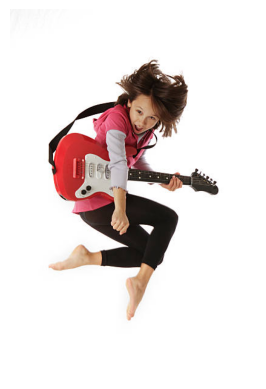

Image 1: Similarity Score: 0.50580233335495	 Path: D:/AIC_EITA/archive/images\2561319255_ce5ede291e.jpg


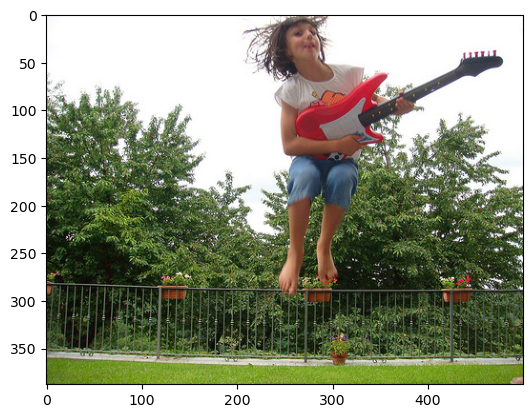

Image 2: Similarity Score: 0.48704081773757935	 Path: D:/AIC_EITA/archive/images\2485467050_1d5e2696d4.jpg


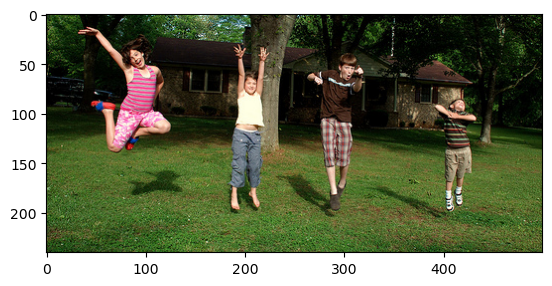

Image 3: Similarity Score: 0.4849272668361664	 Path: D:/AIC_EITA/archive/images\2423856014_8df0e7f656.jpg


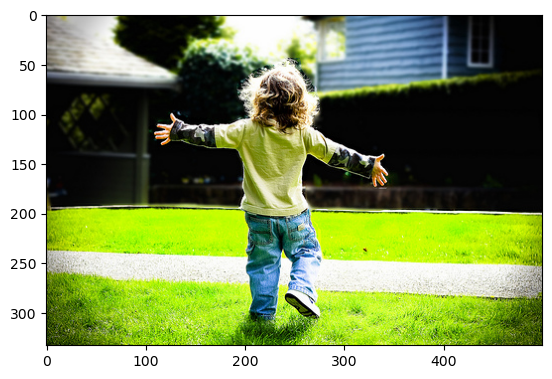

Image 4: Similarity Score: 0.48413026332855225	 Path: D:/AIC_EITA/archive/images\2490768374_45d94fc658.jpg


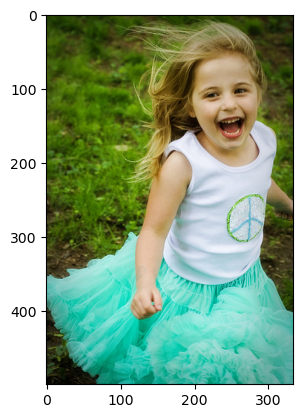

Image 5: Similarity Score: 0.48231372237205505	 Path: D:/AIC_EITA/archive/images\2453990033_df53f0d8c8.jpg


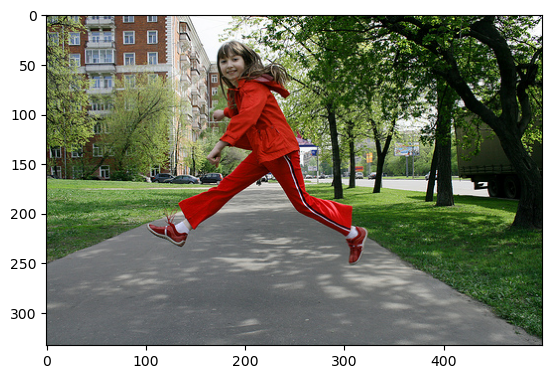

In [7]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load data
base_image_path = "D:/AIC_EITA/archive/images"

image_path = "C:/Users/HIEN/CLIP4Cir/girl_playing_guitar.jpg"
text = "green trees in the background"

# Tokenize
text_inputs = clip.tokenize(text, context_length=77).to(device)

# Encode the text+image query
with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    reference_image_features = clip_model.encode_image(image)
    batch_predicted_features = combining_function(reference_image_features.reshape(1,640), text_features)

# Save embeddings in combine_features
combine_features = torch.empty((0, clip_model.visual.output_dim)).to(device, non_blocking=True)
combine_features = torch.vstack((combine_features, F.normalize(batch_predicted_features, dim=-1)))

# Calculate cosine similarity between query and each of image in dataset
img_feature_list = torch.load("D:/AIC_EITA/archive/pretrained.pt")
similarities = []
for img_path, img_features in img_feature_list:
    img_features = F.normalize(img_features, dim=-1)  # Normalize the image features
    similarity = torch.nn.functional.cosine_similarity(img_features, combine_features, dim=1).item()
    full_img_path = os.path.join(base_image_path, img_path)
    similarities.append((full_img_path, similarity))

# Sort similarities in descending order (most similar first)
similarities.sort(key=lambda x: x[1], reverse=True)

# Load query
print(f"Query text: {text}")
print("Query image")
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)

# Retrieve top 5 most similar images
top_5_similar_images = similarities[:5]
plt.axis('off')  # Hide axes
plt.show()
for idx, (img_path, similarity) in enumerate(top_5_similar_images, start=1):
    print(f"Image {idx}: Similarity Score: {similarity}\t Path: {img_path}")
    im = plt.imread(img_path)
    plt.imshow(im)
    plt.show()
